In [2]:
import numpy as np
import copy

from treks import htr, tr, get_treks
from HTC import HTC_identifiable
from EID import EID_identifiable
from TSID import TSID_identifiable
from EID_TSID import EID_TSID_identifiable
from helpers import id_to_edges, graph_to_id, vizualize_graph

from tabulate import tabulate
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

np.random.seed(0)
np.set_printoptions(precision=3, suppress=True)

In [3]:
class DMG():
    def __init__(self, nodes, edges, omitted_nodes = [], prime = 2**31-1):
        self.nodes = nodes
        self.omitted_nodes = omitted_nodes
        self.all_nodes = nodes + omitted_nodes
        self.edges = edges
        self.prime = prime
        self.GF = galois.GF(self.prime)

        self.N_nodes = len(nodes)
        self.N_omitted = len(self.omitted_nodes)
        self.N_total = len(self.all_nodes)
        
        self.HTC_identifiable = None
        self.EID_identifiable = None
        self.TSID_identifiable = None
        self.EID_TSID_identifiable = None
        
        self.var_to_int = {}
        self.str_to_var = {}

        # Initialize empty parameters
        self.Lambda = self.GF.Zeros((self.N_nodes, self.N_nodes))
        self.extended_Lambda = self.GF.Zeros((self.N_total, self.N_total))
        self.Omega = self.GF.Zeros((self.N_nodes, self.N_nodes))
        self.Sigma = self.GF.Zeros((self.N_nodes, self.N_nodes))

        # Create graph structure
        self.create_variables()
        self.set_parent_child()
        self.set_siblings()
        self.set_descendents()
        self.reset_id_grid()

    
    def create_variables(self):
        # Create a variable for each of the nodes
        self.variables = []
        self.omitted_variables = []

        
        for index, node in enumerate(self.nodes):
            # instantiate observed variables
            variable = Variable(node)
            self.variables.append(variable)
            self.var_to_int[variable] = index
            self.str_to_var[node] = variable

        for o_node in self.omitted_nodes:
            # instantiate omitted variables
            variable = Variable(o_node, True)
            self.omitted_variables.append(variable)

        self.all_variables = self.variables + self.omitted_variables

        return self.variables

    
    def set_parent_child(self):
        for row_id, row_var in enumerate(self.all_variables):
            for col_id, col_var in enumerate(self.all_variables):
                for edge in self.edges:
                    # if row variable is a parent of the column variable
                    if row_var.name == edge[0] and col_var.name == edge[1]:
                        # set parent-child relation and set the lambda value
                        col_var.add_parent(row_var)
                        row_var.add_child(col_var)

        return self.variables


    def set_siblings(self):
        # go trough each pair of variables
        for var1_id, var1 in enumerate(self.variables):
            for var2 in self.variables[var1_id + 1:]:
                for o_parent in var1.o_parents:
                    # for each variable, check if they have the same omitted parents
                    if o_parent in var2.o_parents:
                        # set sibling status for both variables
                        var1.add_sibling(var2)
                        var2.add_sibling(var1)

        return self.variables

    
    def set_descendents(self):
        for var in self.variables:
            var.add_descendents()

        return self.variables

    
    def reset_id_grid(self):
        self.id_grid = np.zeros((self.N_nodes, self.N_nodes))
        
        for var_id, var in enumerate(self.variables):
            for child in var.children:
                child_id = self.var_to_int[child]
                self.id_grid[var_id, child_id] = -1

        return self.id_grid
                

    def generate_parameters(self):  
        self.gen_Lambda()
        self.gen_Omega()
        self.gen_Sigma()

    
    def gen_Lambda(self):
        for var_id, var in enumerate(self.all_variables):
            for child in var.children:
                child_id = self.var_to_int[child]
                lambd = self.GF(np.random.randint(1, self.prime))
                self.extended_Lambda[var_id][child_id] = lambd

        self.Lambda = self.extended_Lambda[:self.N_nodes, :self.N_nodes]

        return self.Lambda

    
    def gen_Omega(self):
        for var_id, var in enumerate(self.variables):
            variance = self.GF(np.random.randint(1, self.prime))
            self.Omega[var_id][var_id] = variance

            for sibling in var.siblings:
                cov = self.GF(np.random.randint(1, self.prime))
                sib_id = self.var_to_int[sibling]
                self.Omega[var_id][sib_id] = cov
                self.Omega[sib_id][var_id] = cov

        return self.Omega

    
    def gen_Sigma(self):
        if not self.Lambda.any():
            self.gen_Lambda()
        if not self.Omega.any():
            self.gen_Omega()

        ILambd = self.GF.Identity(self.N_nodes) - self.Lambda
        ILambd_inv = np.linalg.inv(ILambd)
        self.Sigma = np.matmul(ILambd_inv.T, np.matmul(self.Omega, ILambd_inv))
        
        return self.Sigma
        

    def Lambda_HTC(self, Sigma, order, Lambda = None):
        if Lambda == None:
            Lambda = self.GF.Zeros((self.N_nodes, self.N_nodes)) 

        det_multiplier = {}
        I = self.GF.Identity(self.N_nodes)
        
        for item in order:
            var, Yv = item
            var_id = self.var_to_int[var]
            A = self.GF.Zeros((len(var.parents), len(var.parents)))
            b = self.GF.Zeros(len(var.parents))
            
            ILambdT_Sig = np.matmul((I - Lambda).T, Sigma)
            htr_var = htr(self, var)
            
            for Yvar_index, Yvar in enumerate(Yv):
                Yvar_id = self.var_to_int[Yvar]
                
                for parent_index, parent in enumerate(var.parents):
                    parent_id = self.var_to_int[parent]
                
                    if Yvar in htr_var:      
                        A[Yvar_index, parent_index] = ILambdT_Sig[Yvar_id, parent_id]
                
                    else:
                        A[Yvar_index, parent_index] = Sigma[Yvar_id, parent_id]

                if Yvar in htr_var:
                    b[Yvar_index] = ILambdT_Sig[Yvar_id, var_id]
                    
                else:
                    b[Yvar_index] = Sigma[Yvar_id, var_id]
                    
            
            if var.parents:
                det = np.linalg.det(A)

                if det == 0:
                    Lambda = self.GF.Zeros((self.N_nodes, self.N_nodes))
                    det_multiplier = {}

                    return Lambda, det_multiplier

                Lambda_new = np.matmul(np.linalg.inv(A), b)
    
                for parent_index, parent in enumerate(var.parents):
                    parent_id = self.var_to_int[parent]
                    Lambda[parent_id, var_id] = Lambda_new[parent_index]
    
                det_multiplier[var] = det

        return Lambda, det_multiplier
        

    def Lambda_EID(self, Sigma, order, Lambda = None):    
        if not np.any(Lambda):
            Lambda = self.GF.Zeros((self.N_nodes, self.N_nodes))
            
        det_multiplier = {}
        
        for v, W, Y in order:        
            # Calculate the A matrix
            A = self.GF.Zeros((len(W), len(W)))
            b = self.GF.Zeros(len(W))
            v_id = self.var_to_int[v]

            for y_index, y in enumerate(Y):
                y_id = self.var_to_int[y]

                H = []
                for parent in y.parents:
                    parent_id = self.var_to_int[parent]

                    if not Lambda[parent_id, y_id] == 0:
                        H.append(parent)

                for w_index, w in enumerate(W):
                    w_id = self.var_to_int[w]
                    h_sum_1 = self.GF(0)

                    for h in H:
                        h_id = self.var_to_int[h]
                        h_sum_1 += Sigma[h_id, w_id]*Lambda[h_id, y_id]

                    A[y_index, w_index] = Sigma[y_id, w_id] - h_sum_1

                # calculate rhs of the equation:
                p_sum = self.GF(0)
                for p in (set(v.parents) - set(W)):
                    p_id = self.var_to_int[p]

                    h_sum_2 = self.GF(0)
                    for h in H:
                        h_id = self.var_to_int[h]
                        h_sum_2 += Sigma[h_id, p_id]*Lambda[h_id, y_id]

                    if (Sigma[y_id, p_id] - h_sum_2):   
                        p_sum += (Sigma[y_id, p_id] - h_sum_2)*Lambda[p_id, v_id]

                h_sum_3 = self.GF(0)
                for h in H:
                    h_id = self.var_to_int[h] 
                    h_sum_3 += Sigma[v_id, h_id]*Lambda[h_id, y_id]
      
                b[y_index] = Sigma[y_id, v_id] - p_sum - h_sum_3

            det = np.linalg.det(A)

            if det == 0:
                Lambda = self.GF.Zeros((self.N_nodes, self.N_nodes))
                det_multiplier = {}

                return Lambda, det_multiplier
                
            A_inv = np.linalg.inv(A)
                        
            new_lambda = np.matmul(A_inv, b)

            for w_index, w in enumerate(W):
                w_id = self.var_to_int[w]
                lambd = new_lambda[w_index]
                Lambda[w_id, v_id] = new_lambda[w_index]

            if det_multiplier.get(v, None):
                det_multiplier[v] = det_multiplier[v] * det

            else:
                det_multiplier[v] = det

        return Lambda, det_multiplier
        

    def Lambda_TSID(self, Sigma, order, Lambda = None):
        if not np.any(Lambda):
            Lambda = self.GF.Zeros((self.N_nodes, self.N_nodes))

        det_multiplier = {}

        for item in order:
            w0, var, S_comb, T_comb = item
            w0_id = self.var_to_int[w0]
            var_id = self.var_to_int[var]
            
            S_ids = [self.var_to_int[key] for key in S_comb]
            T_ids = [self.var_to_int[key] for key in T_comb]
        
            col_ids = T_ids + [var_id]
            det1 = np.linalg.det(Sigma[S_ids, :][:, col_ids])
        
            col_ids = T_ids + [w0_id]
            det2 = np.linalg.det(Sigma[S_ids, :][:, col_ids])

            lambda_sum = self.GF(0)
            
            for parent in var.parents:
                parent_id = self.var_to_int[parent]
                
                if self.id_grid[parent_id, var_id] == 1 and parent != w0:
                    lamb = Lambda[parent_id, var_id]
                    col_ids = T_ids + [parent_id]
                    det3 = np.linalg.det(Sigma[S_ids, :][:, col_ids])

                    lambda_sum = lambda_sum + lamb*det3

            if det2 == 0:
                Lambda = self.GF.Zeros((self.N_nodes, self.N_nodes))
                det_multiplier = {}

                return Lambda, det_multiplier

            Lambda[w0_id, var_id] = (det1 - lambda_sum)/det2

            if det_multiplier.get(var, None):
                det_multiplier[var] = det_multiplier[var] * det2
    
            else:
                det_multiplier[var] = det2

            
        return Lambda, det_multiplier
            
    
    def Lambda_EID_TSID(self, Sigma, order):
        Lambda = self.GF.Zeros((self.N_nodes, self.N_nodes)) 
        det_multiplier = {}

        for item in order:
            if item[0] == "EID":
                EID_order = item[1]
                Lambda, EID_mult = self.Lambda_EID(Sigma, EID_order, Lambda=Lambda)

                for var in EID_mult:
                    if det_multiplier.get(var, None):
                        det_multiplier[var] = det_multiplier[var] * EID_mult[var]
    
                    else:
                        det_multiplier[var] = EID_mult[var]

                if not np.any(Lambda):
                    Lambda_tilde = Lambda
            
                    return Lambda_tilde, det_multiplier
  
            elif item[0] == "TSID":
                TSID_order = item[1]
                Lambda, TSID_mult = self.Lambda_TSID(Sigma, TSID_order, Lambda=Lambda)

                for var in TSID_mult:
                    if det_multiplier.get(var, None):
                        det_multiplier[var] = det_multiplier[var] * TSID_mult[var]
    
                    else:
                        det_multiplier[var] = TSID_mult[var]
                
                if not np.any(Lambda):
                    Lambda_tilde = Lambda
            
                    return Lambda_tilde, det_multiplier

        return Lambda, det_multiplier

    
    def Lambda_tilde(self, Sigma, method):      
        Lambda_tilde = self.GF.Identity(self.N_nodes)
        
        # Check if the graph is HTC identifiable
        if method == "HTC":
            if self.HTC_identifiable == None:
                self.HTC_identifiable, self.HTC_order = HTC_identifiable(self)

            # Raise exception for non-HTC identifiable graphs
            if self.HTC_identifiable == False:
                raise Exception("Graph not HTC identifiable")

            Lambda, det_multiplier = self.Lambda_HTC(Sigma, self.HTC_order)


        elif method == "EID":
            # Check if the graph is EID identifiable
            if self.EID_identifiable == None:
                self.EID_identifiable, self.EID_order = EID_identifiable(self)
    
            # Raise exception for non-EID identifiable graphs
            if self.EID_identifiable == False:
                raise Exception("Graph not EID identifiable")
            
            Lambda, det_multiplier = self.Lambda_EID(Sigma, self.EID_order)


        elif method == "TSID":
            # Check if the graph is TSID identifiable
            if self.TSID_identifiable == None:
                self.TSID_identifiable, self.TSID_order = TSID_identifiable(self)
    
            # Raise exception for non-TSID identifiable graphs
            if self.TSID_identifiable == False:
                raise Exception("Graph not TSID identifiable")

            Lambda, det_multiplier = self.Lambda_TSID(Sigma, self.TSID_order)


        elif method == "EID_TSID":
            # Check if the graph is EID_TSID identifiable
            if self.EID_TSID_identifiable == None:
                self.EID_TSID_identifiable, self.EID_TSID_order = EID_TSID_identifiable(self)
            
            # Raise exception for non-TSID identifiable graphs
            if self.EID_TSID_identifiable == False:
                raise Exception("Graph not EID + TSID identifiable")
                
            Lambda, det_multiplier = self.Lambda_EID_TSID(Sigma, self.EID_TSID_order)

        else:
            raise Exception("Choose a valid identificaton method")

        
        for v in det_multiplier:
            v_id = self.var_to_int[v]
            Lambda_tilde[:, v_id] = (Lambda_tilde[:, v_id] - Lambda[:, v_id]) * det_multiplier[v]

        
        if not np.any(Lambda):
            Lambda_tilde = Lambda
                        
        return Lambda_tilde

        
    def Omega_tilde(self, Sigma, Lambda_tilde):
        Omega_tilde = np.matmul(Lambda_tilde.T, np.matmul(Sigma, Lambda_tilde))
        
        return Omega_tilde

In [4]:
class Variable():
    def __init__(self, name, omitted=False):
        self.name = name
        self.all_parents = []
        self.o_parents = []
        self.parents = []
        self.children = []
        self.siblings = []
        self.omitted = omitted
        self.Yv = []
        
        
    def add_parent(self, parent):
        self.all_parents.append(parent)

        if parent.omitted == False:
            self.parents.append(parent)
        else:
            self.o_parents.append(parent)

        return 

    
    def add_child(self, child):
        self.children.append(child)

        return self.children

        
    def add_sibling(self, node):
        self.siblings.append(node)

        return self.siblings
        
    
    def add_Yv(self, var):
        self.Yv.append(var)

        return self.Yv

    def add_descendents(self):
        self.descendents = []
        children = self.children
        
        change = True
        while change:
            change = False
            
            for child in children:
                if not child in self.descendents:
                    self.descendents.append(child)
                    children = children + child.children
                    change = True
                
        
    def __repr__(self):
        return self.name

In [5]:
def model_contained(G, G_prime, method):
    contained = True
    G.generate_parameters()
    Lambda_tilde = G_prime.Lambda_tilde(G.Sigma, method)

    if np.all(Lambda_tilde == 0):
        return "INC"

    Omega_tilde = G_prime.Omega_tilde(G.Sigma, Lambda_tilde)

    for var in G_prime.variables:
        for var_2 in G_prime.variables:
            if not var_2 in var.siblings and var != var_2:
                var_id = G_prime.var_to_int[var]
                var_2id = G_prime.var_to_int[var_2]

                if not Omega_tilde[var_id, var_2id] == 0:
                    contained = False
                     
    return contained

In [6]:
def algebraic_equivalence(graph_a, graph_b, method):
    a_in_b = model_contained(graph_a, graph_b, method)
    b_in_a = model_contained(graph_b, graph_a, method)

    if (a_in_b == "INC" and b_in_a == "INC") or (a_in_b == "INC" and b_in_a == True) or (a_in_b == True and b_in_a == "INC"):
        return "INC"
                
    elif a_in_b == True and b_in_a == True:
        equivalence = True

    else:
        equivalence = False
                                
    return equivalence

In [7]:
# Two algebraically equivalent graphs
nodes = ["a", "b", "c", "d", "e"]
omitted_nodes = ["o1", "o2", "o3", "o4"]
edges = [("o1", "a"), ("o1", "c"), ("o2", "b"), ("o2", "c"), ("o3", "c"), ("o3", "e"), ("o4", "b"), ("o4", "d"), ("a", "d"), ("c", "d"), ("b", "e"), ("b", "a"), ("e", "a")]
graph_a = DMG(nodes, edges, omitted_nodes)

nodes = ["a", "b", "c", "d", "e"]
omitted_nodes = ["o1", "o2", "o3", "o4", "o5"]
edges = [("o1", "a"), ("o1", "c"), ("o2", "b"), ("o2", "c"), ("o3", "c"), ("o3", "e"), ("o4", "b"), ("o4", "d"), ("o5", "a"), ("o5", "e"), ("a", "d"), ("c", "d"), ("b", "e"), ("b", "a")]
graph_b = DMG(nodes, edges, omitted_nodes)

algebraic_equivalence(graph_a, graph_b, method="EID_TSID")

True

INC


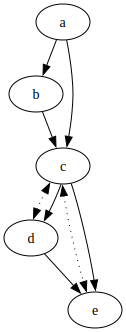

In [8]:
# Spurious component using HTC-method:
nodes = ["a", "b", "c", "d", "e"]
omitted_nodes = ["o1", "o2"]
edges = [("o1", "c"), ("o1", "d"), ("o2", "c"), ("o2", "e"), ("a", "b"), ("a", "c"), ("b", "c"), ("c", "d"), ("c", "e"), ("d", "e")]
graph1 = DMG(nodes, edges, omitted_nodes, prime=9973)

nodes = ["a", "b", "c", "d", "e"]
omitted_nodes = ["o1", "o2"]
edges = [("o1", "c"), ("o1", "d"), ("o2", "e"), ("o2", "b"), ("a", "b"), ("a", "e"), ("d", "e"), ("d", "b"), ("c", "e"), ("c", "b")]
graph2 = DMG(nodes, edges, omitted_nodes, prime=9973)

graph1.HTC_identifiable, graph1.HTC_order = HTC_identifiable(graph1)

a, b, c, d, e = graph1.variables
graph1.HTC_order = [[a, []], [b, [a]], [c, [b, a]], [d, [a]], [e, [a, d]]]

MC = model_contained(graph2, graph1, method="HTC")
print(MC)

vizualize_graph(graph1)

In [9]:
nodes = ["a", "b", "c", "d", "e"]
database = [
    [45, 15], [107, 15], [1099, 15], [1182, 58], [1197, 58], [45, 79], 
    [1114, 85], [1182, 86], [1146, 92], [60, 113], [300, 113], [360, 113], 
    [364, 113], [376, 113], [484, 113], [1114, 113], [4456, 113], [5288, 113], 
    [360, 115], [360, 117], [60, 121], [300, 121], [4746, 172], [4747, 172], 
    [6275, 172], [6307, 172], [4746, 188], [6275, 188], [1452, 195], [5832, 195], 
    [364, 209], [364, 217], [5064, 226], [5304, 226], [5544, 226], [45, 271], 
    [333, 278], [453, 278], [461, 278], [845, 284], [492, 291], [5320, 291], 
    [5352, 291], [5832, 291], [45, 303], [1452, 305], [5288, 305], [5544, 305], 
    [5513, 308], [13704, 308], [5288, 309], [1114, 341], [333, 342], [453, 342], 
    [860, 354], [5240, 354], [5480, 354], [60, 369], [300, 369], [360, 369], 
    [60, 373], [300, 373], [841, 387], [845, 393], [4696, 401], 
    [4936, 401], [329, 402], [453, 402], [840, 402], [841, 402], 
    [844, 402], [4680, 402], [4696, 402], [4936, 402], [5768, 402], 
    [329, 403], [840, 403], [4680, 403], [329, 406], [4680, 406], 
    [453, 410], [5304, 417], [348, 449], [380, 449], [860, 449], 
    [5480, 449], [329, 466], [840, 466], [4680, 466], [4696, 466], 
    [329, 470], [4680, 470], [107, 527], [5769, 534], [4489, 562], 
    [5513, 562], [13704, 562], [360, 625], [376, 625], [360, 627], 
    [5257, 658], [5257, 659], [4746, 676], [6275, 676], [4993, 802], 
    [841, 899], [329, 914], [840, 914], [841, 914], [4680, 914], 
    [329, 915], [840, 915]
]

EID_graphs = []
EID_ids = []

EID_TSID_graphs = []
EID_TSID_ids = []

Identifiable_graphs = []
Identifiable_ids = []

for graph_id in database:
    edges, omitted_nodes = id_to_edges(nodes, graph_id)
    graph = DMG(nodes, edges, omitted_nodes)

    eid, order = EID_identifiable(graph)

    if eid:
        EID_graphs.append(graph)
        EID_ids.append(graph_id)
        
        Identifiable_graphs.append(graph)  
        Identifiable_ids.append(graph_id)


for graph_id in database:
    edges, omitted_nodes = id_to_edges(nodes, graph_id)
    graph = DMG(nodes, edges, omitted_nodes)
    graph.generate_parameters()

    graph.EID_TSID_identifiable, graph.EID_TSID_order = EID_TSID_identifiable(graph)
        
    if graph.EID_TSID_identifiable:
        EID_TSID_graphs.append(graph)
        EID_TSID_ids.append(graph_id)

        if not graph_id in EID_ids:
            Identifiable_graphs.append(graph)
            Identifiable_ids.append(graph_id)

print(f"Amount of EID identifiable graphs: {len(EID_graphs)}")
print(f"Amount of EID+TSID identifiable graph: {len(Identifiable_graphs)}")

Amount of EID identifiable graphs: 23
Amount of EID+TSID identifiable graph: 98


In [51]:
def compare_graphs(graph_list):
    n_graphs = len(graph_list)
    grid = np.empty((n_graphs, n_graphs), dtype="object")
    grid_numeric = np.empty((n_graphs, n_graphs))
    mapping = {True: 1, False: 0, "INC": 2}
    
    for graph1_index in tqdm(range(n_graphs)):
        for graph2_index in range (n_graphs):
            graph1 = graph_list[graph1_index]
            graph2 = graph_list[graph2_index]
            
            contained = model_contained(graph1, graph2, method="EID_TSID")
            
            grid[graph1_index, graph2_index] = contained
            grid_numeric[graph1_index, graph2_index] = mapping[contained]
            
    return grid_numeric

In [50]:
def graph_from_parameters(Lambda, Omega):
    alphabet = ["", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
    num_variables = Lambda.shape[0]
    nodes = []
    omitted_nodes = []

    for i in range(num_variables):
        node_name = alphabet[i // 26] + alphabet[(i % 26) + 1]
        nodes.append(node_name)

    edges = []
    omitted_count = 0
    
    for row_id in range(num_variables):
        for col_id in range(num_variables):
            if Lambda[row_id, col_id]:
                edges.append((nodes[row_id], nodes[col_id]))

            if col_id > row_id:
                if Omega[row_id, col_id]:
                    omitted_count += 1
                    omitted_nodes.append(f"o{omitted_count}")
                    edges.append((f"o{omitted_count}", nodes[row_id]))
                    edges.append((f"o{omitted_count}", nodes[col_id]))

    graph = DMG(nodes, edges, omitted_nodes)

    return graph

In [76]:
def plot_grid(grid_numeric, graph_ids=[], save=False):
    colors = ["#e82c39", "#4257f5", "#0a0000"]
    cmap = mcolors.ListedColormap(colors)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(grid_numeric, cmap=cmap, vmin=0, vmax=2)

    ax.set_xticks(np.arange(-0.5, np.shape(grid_numeric)[0], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, np.shape(grid_numeric)[0], 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)

    if graph_ids:  
        num_graphs = len(graph_ids)
        font_size = 10 - num_graphs/50
        ax.set_xticks(np.arange(num_graphs))
        ax.set_xticklabels(graph_ids, rotation=90, fontsize=font_size)
        
        ax.set_yticks(np.arange(len(graph_ids)))
        ax.set_yticklabels(graph_ids, fontsize=font_size)
    
    ax.set_xlabel("G'")
    ax.set_ylabel("G")

    if save == True:
        plt.savefig('plot.png')
        
    plt.show()



Comparing EID identifiable graphs...


100%|███████████████████████████████████████████| 23/23 [00:01<00:00, 14.46it/s]


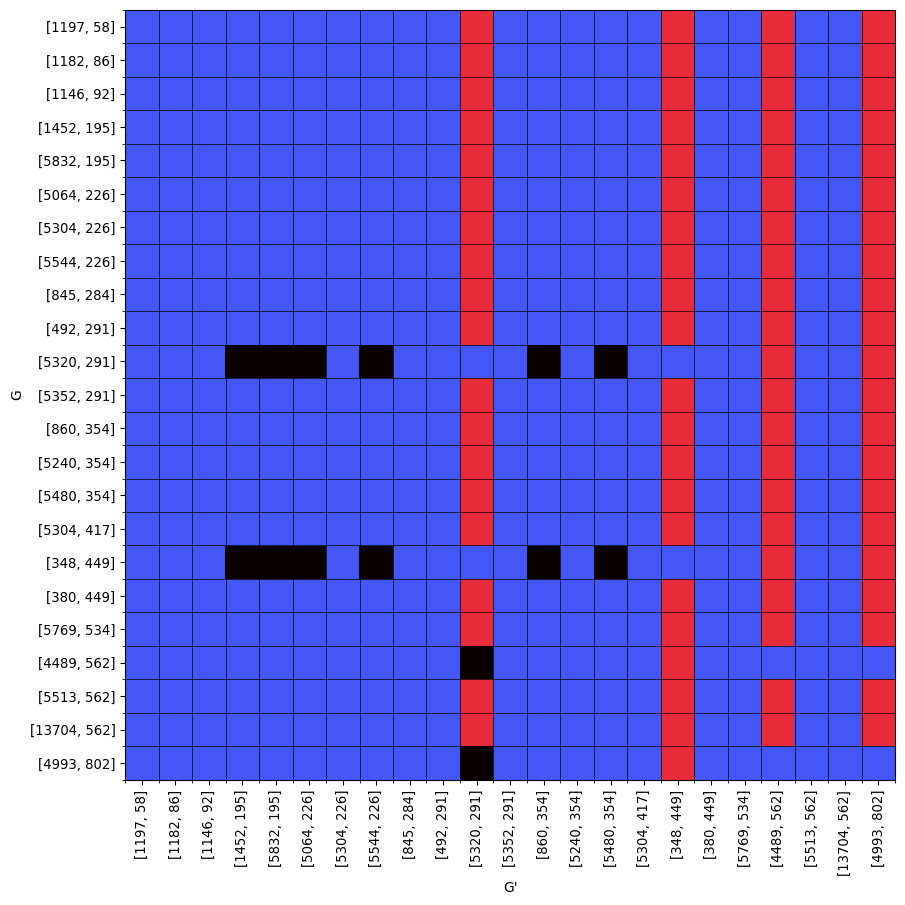

In [14]:
print("Comparing EID identifiable graphs...")
grid_numeric_EID = compare_graphs(EID_graphs)
plot_grid(grid_numeric_EID, EID_ids)

Comparing EID+TSID identifiable graphs


100%|███████████████████████████████████████████| 98/98 [00:25<00:00,  3.89it/s]


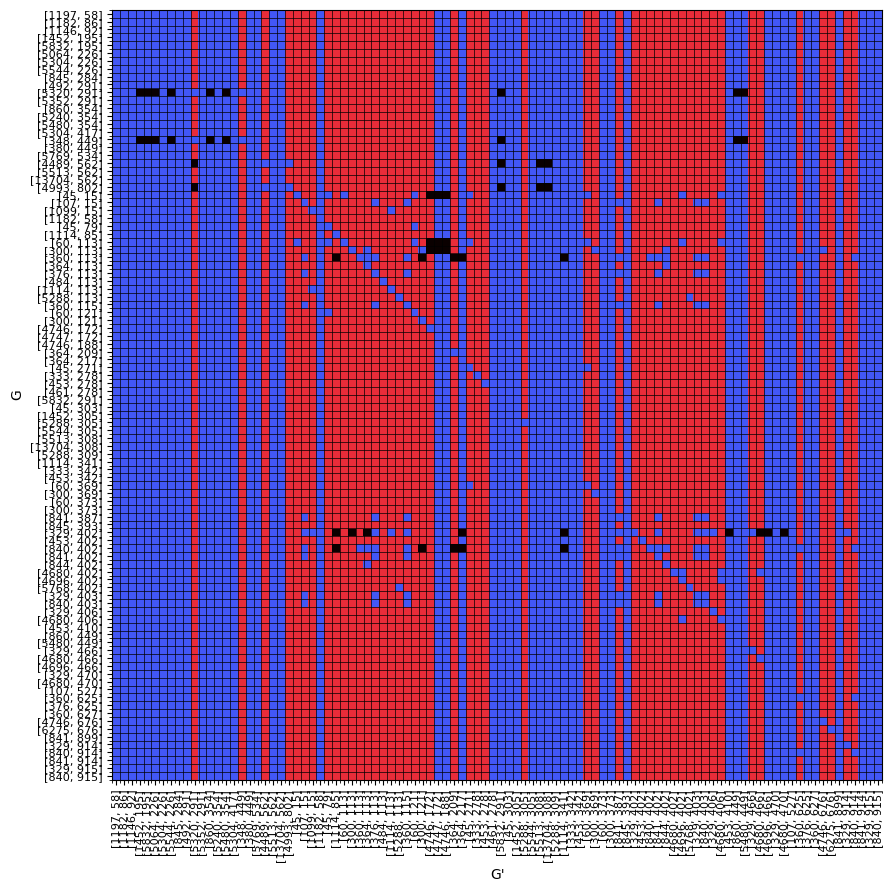

In [15]:
print("Comparing EID+TSID identifiable graphs")
grid_numeric_EID_TSID = compare_graphs(Identifiable_graphs)
plot_grid(grid_numeric_EID_TSID, Identifiable_ids)

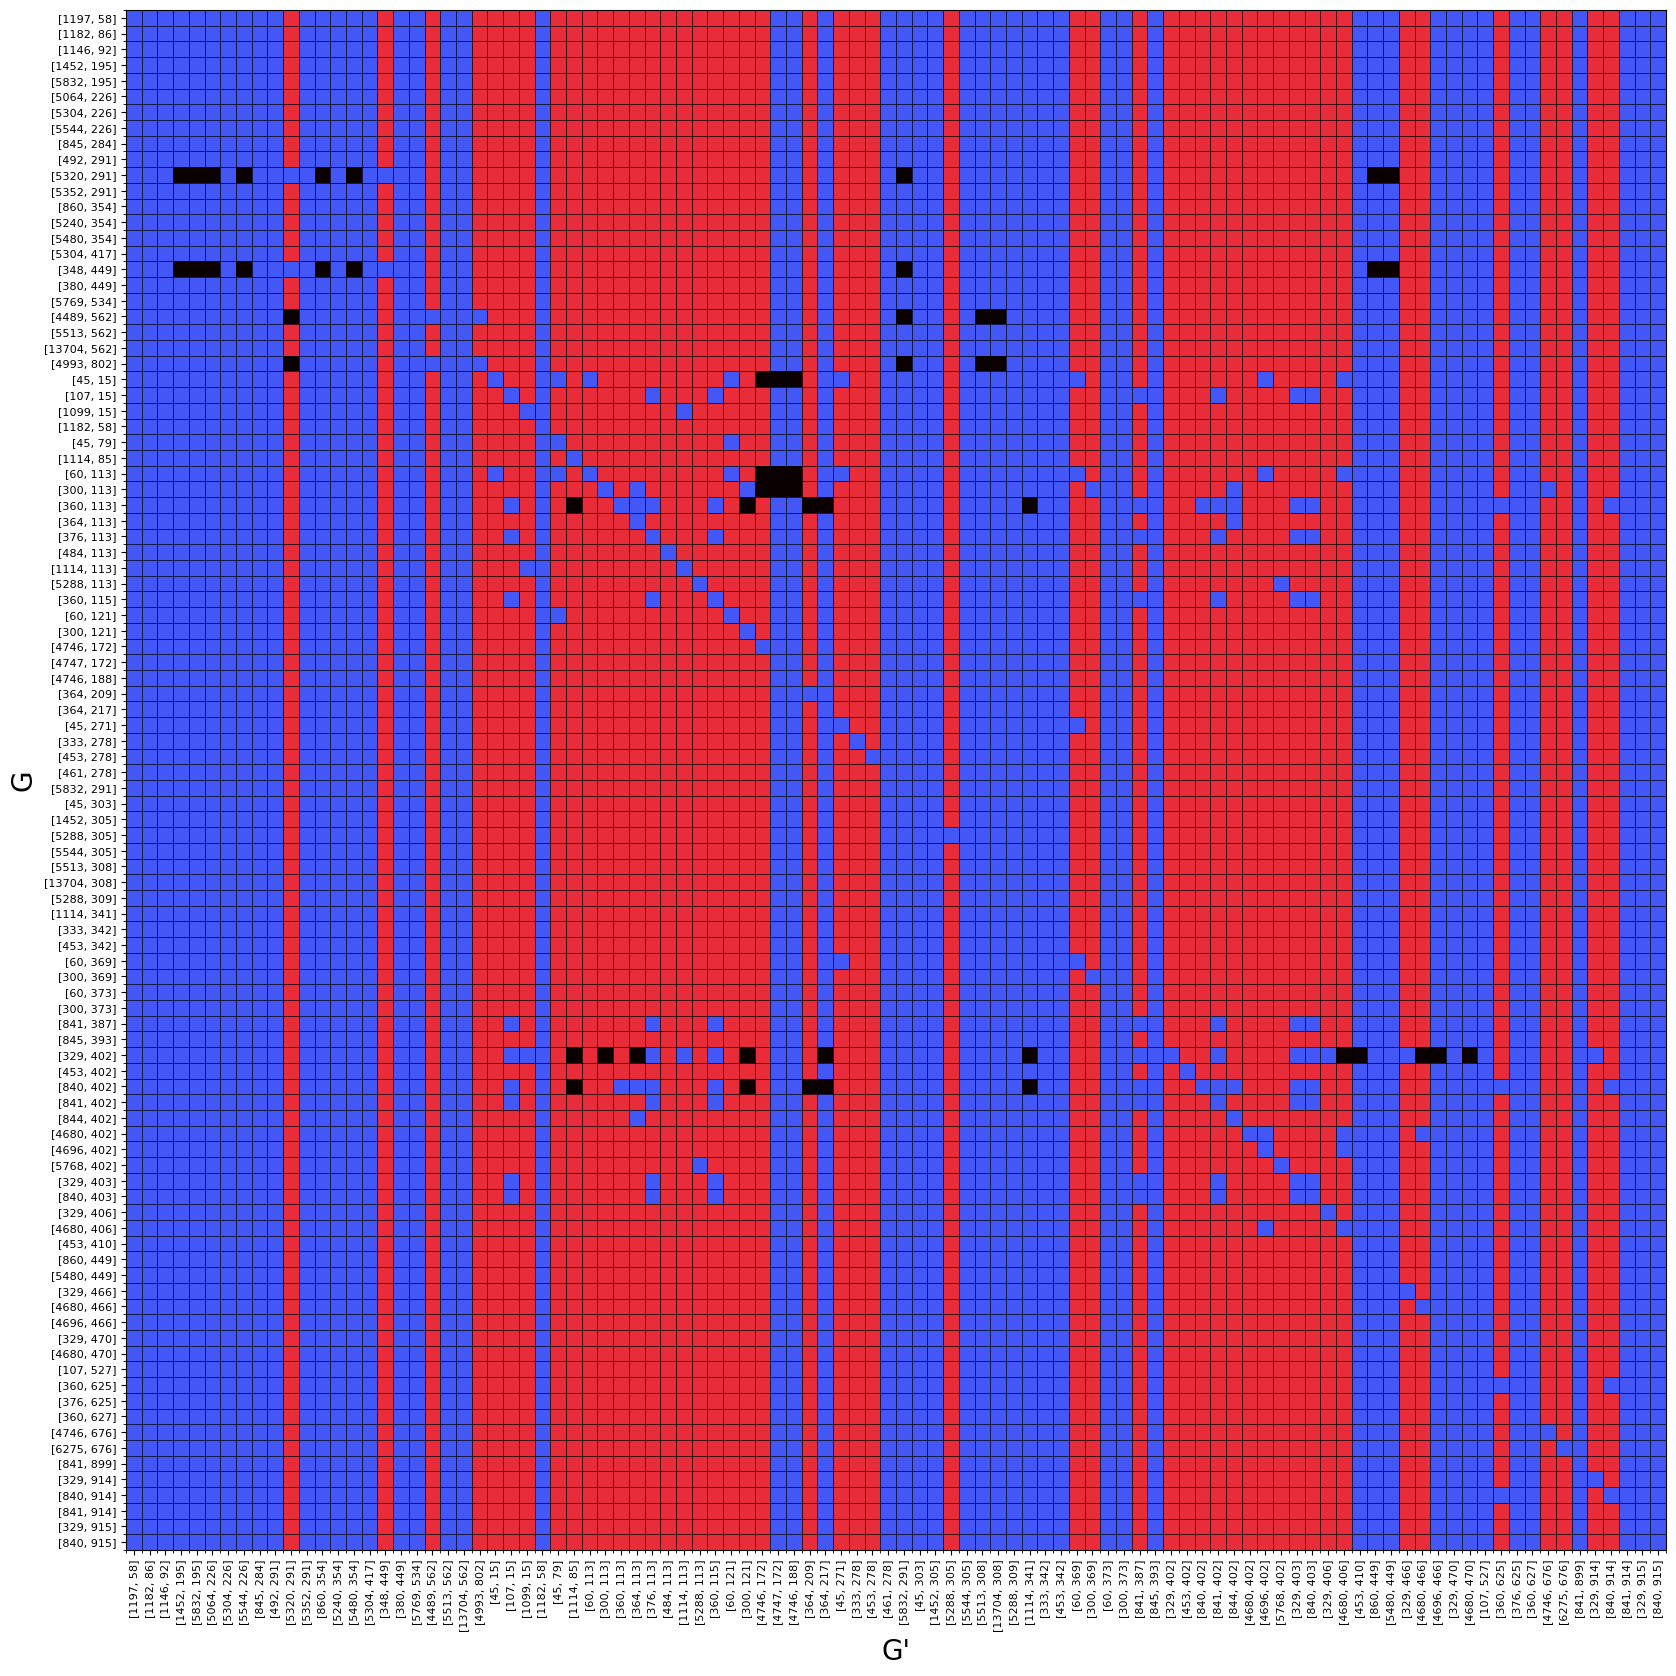

In [171]:
graph_ids = []
for item in ID_set:
    graph_ids.append(item[0])

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(grid_numeric_EID_TSID, cmap=cmap, vmin=0, vmax=2)

ax.set_xticks(np.arange(-0.5, np.shape(grid_numeric_EID_TSID)[0], 1), minor=True)
ax.set_yticks(np.arange(-0.5, np.shape(grid_numeric_EID_TSID)[0], 1), minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)

ax.set_xticks(np.arange(len(graph_ids)))
ax.set_xticklabels(graph_ids, rotation=90, fontsize=8)

ax.set_yticks(np.arange(len(graph_ids)))
ax.set_yticklabels(graph_ids, fontsize=8)

ax.set_xlabel("G'", fontsize=20)
ax.set_ylabel("G", fontsize=20)
plt.show()

In [51]:
nodes = ["a", "b", "c", "d", "e"]

edges1, omitted_nodes1 = id_to_edges(nodes, [4489, 562])
graph1 = DMG(nodes, edges1, omitted_nodes1, prime=4999)

edges2, omitted_nodes2 = id_to_edges(nodes, [1197, 58])
graph2 = DMG(nodes, edges2, omitted_nodes2, prime=4999)
TC = 0
IC = 0
FC = 0
n = 100000
for i in tqdm(range(n)):
    graph1.generate_parameters()
    graph2.generate_parameters()

    AE = algebraic_equivalence(graph1, graph2, method="EID")
    if AE == True:
        TC += 1
    if AE == "INC":
        IC += 1
    else:
        FC += 1

100%|██████████████████████████████████| 100000/100000 [10:46<00:00, 154.65it/s]


In [16]:
nodes = ["a", "b", "c", "d", "e"]

edges1, omitted_nodes1 = id_to_edges(nodes, [4489, 562])
graph1 = DMG(nodes, edges1, omitted_nodes1, prime=4999)

edges2, omitted_nodes2 = id_to_edges(nodes, [1197, 58])
graph2 = DMG(nodes, edges2, omitted_nodes2, prime=4999)
TC = 0
IC = 0
FC = 0
n = 1
for i in tqdm(range(n)):
    graph1.generate_parameters()
    graph2.generate_parameters()

    AE = algebraic_equivalence(graph1, graph2, method="EID")
    if AE == True:
        TC += 1
    if AE == "INC":
        IC += 1
    else:
        FC += 1



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.20it/s]


In [17]:
print(f"Expected FP count: {n * (1/4999)} ")
print(f"False positive count: {TC}")
print()
print(f"Expected IC count: {n* (4/4999)}")
print(f"False inconclusive count: {IC}")
graph1.generate_parameters()

print(graph1.Sigma)

Expected FP count: 0.00020004000800160032 
False positive count: 0

Expected IC count: 0.0008001600320064013
False inconclusive count: 0
[[3970 4020  968 1935 4481]
 [4020 4049 2985 1599 2691]
 [ 968 2985 2330    0 2120]
 [1935 1599    0 4036 2576]
 [4481 2691 2120 2576 3006]]


In [81]:
# GRAFEN MET n EDGES

nodes = ["a", "b", "c", "d", "e"]
eight_edges_ids = []
nine_edges_ids = []
ten_edges_ids = []

for graph_id in Identifiable_ids:
    edges, omitted_nodes = id_to_edges(nodes, graph_id)
    graph = DMG(nodes, edges, omitted_nodes)

    graph.generate_parameters()
    nonzero_count = np.count_nonzero(graph.Lambda)

    bi_edges_count = 0
    edges_count = 0
    
    for variable in graph.variables:
        for child in variable.children:
            edges_count += 1
            
        for sibling in variable.siblings:
            bi_edges_count += 1
        
    total_edges = int(bi_edges_count / 2) + edges_count
    
    if total_edges == 8:
        eight_edges_ids.append(graph_id)
        
    elif total_edges == 9:
        nine_edges_ids.append(graph_id)

    elif total_edges == 10:
        ten_edges_ids.append(graph_id)

print(len(eight_edges_ids) + len(nine_edges_ids) + len(ten_edges_ids))

print(f"8: #{len(eight_edges_ids)}")
print(f"9: #{len(nine_edges_ids)}")
print(f"10: #{len(ten_edges_ids)}")

98
8: #7
9: #41
10: #50


Comparing 8-edges identifiable graphs...


100%|█████████████████████████████████████████| 840/840 [26:37<00:00,  1.90s/it]


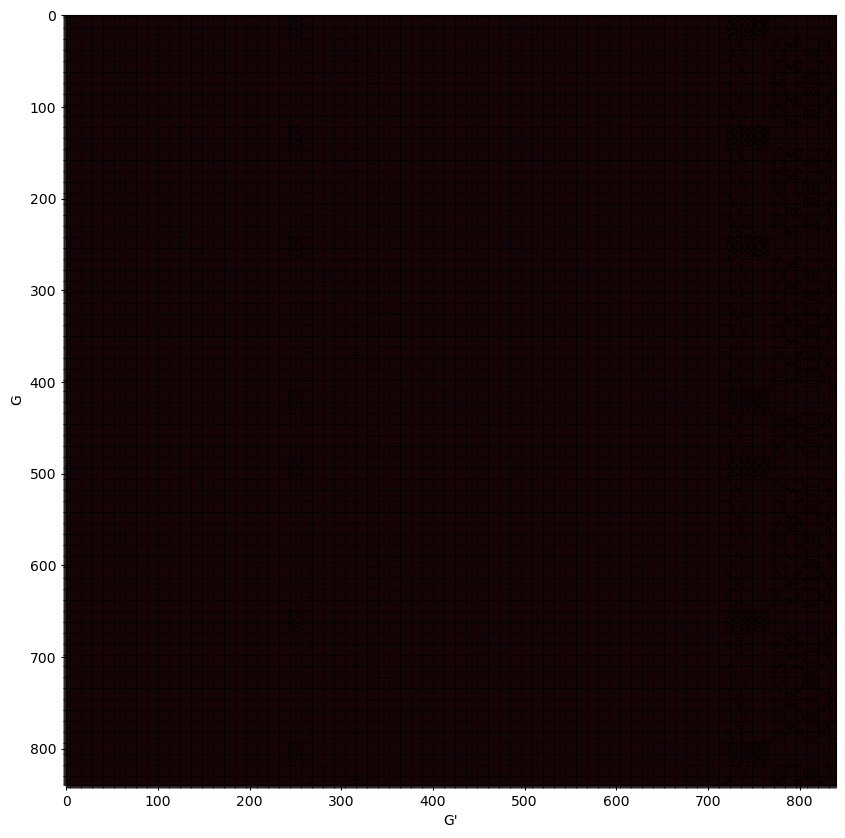

In [62]:
print("Comparing 8-edges identifiable graphs...")
nodes = ["a", "b", "c", "d", "e"]
graph_list = []
permutation_list = []
for graph_id in eight_edges_ids:
    edges, omitted_nodes = id_to_edges(nodes, graph_id)
    graph = DMG(nodes, edges, omitted_nodes)
    graph_list.append(graph)
    permutation_list += permutate_graph(graph)


grid_numeric_8 = compare_graphs(permutation_list)


Comparing 9-edges identifiable graphs...


100%|███████████████████████████████████████████| 41/41 [00:09<00:00,  4.36it/s]


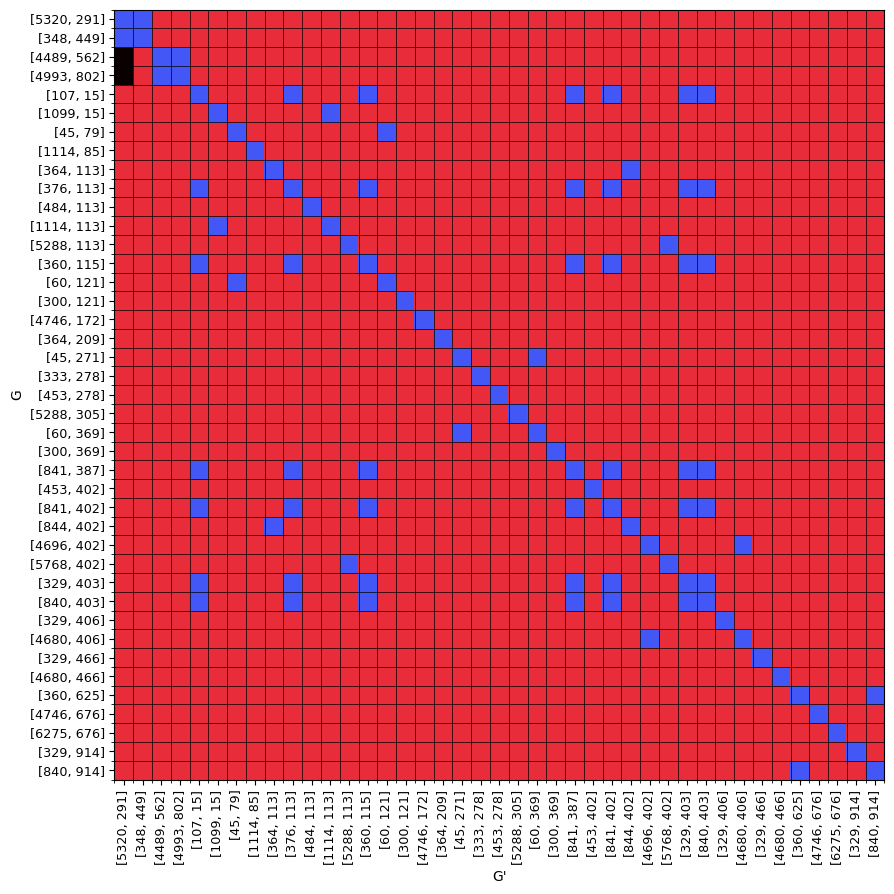

In [82]:
print("Comparing 9-edges identifiable graphs...")
nodes = ["a", "b", "c", "d", "e"]
graph_list = []

for graph_id in nine_edges_ids:
    edges, omitted_nodes = id_to_edges(nodes, graph_id)
    graph = DMG(nodes, edges, omitted_nodes)
    graph_list.append(graph)

grid_numeric_9 = compare_graphs(graph_list)
plot_grid(grid_numeric_9, nine_edges_ids)

In [117]:
cluster1 = [[8218, 678], [8248, 678], [8250, 550], [8250, 676], [8250, 678], [8488, 678], [8504, 674], [8504, 676], [8504, 678]]
cluster2 = [[33360, 434], [34320, 434], [34384, 306], [34384, 402], [34384, 434], [42000, 434], [42512, 402], [42512, 418], [42512, 434]] 
cluster3 = [[2369, 403], [2640, 403], [2880, 403], [2881, 387], [2881, 402], [2881, 403], [2896, 401], [2896, 402], [2896, 403]]

Graad9_1 = [[329, 914], [329, 406], [300, 369], [60, 369], [45, 271]]
Graad9_2 = [[4680, 466], [360, 625], [840, 914], [4680, 466], [360, 625]]

Graad11_1 = [[5288, 305]]
Graad11_2 = [[1114, 85]]
Graad11_3 = [[364, 209]]
Graad11_4 = [[4746, 172]]
Graad11_5 = [[453, 278]]
Graad11_6 = [[333, 278]]

Graad13_1 = [[4746, 676], [844, 402], [364, 113], [484, 113]]
Graad13_2 = [[6275, 676], [1114, 113], [1099, 15], [1114, 113]]
Graad13_3 = [[5288, 113], [768, 402]]


True_cluster_list = [cluster1, cluster2, cluster3, Graad9_1, Graad9_2, Graad11_1, Graad11_2, Graad11_3, Graad11_4, Graad11_5, Graad11_6, Graad13_1, Graad13_2, Graad13_3] 


True
True
True
True
True


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


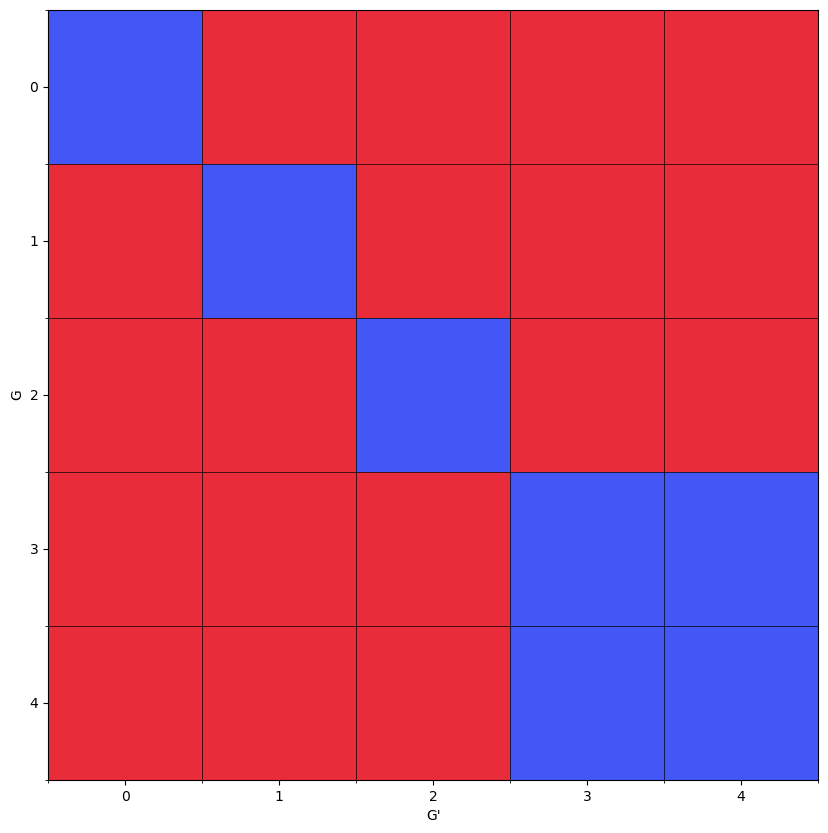

In [134]:
# Comparing Cluster 1:
graph_list = []
for graph_id in Graad9_1:
    edges, omitted_nodes = id_to_edges(nodes, graph_id)
    graph = DMG(nodes, edges, omitted_nodes)
    print(EID_TSID_identifiable(graph)[0])
    if EID_TSID_identifiable(graph)[0] == True:
        graph_list.append(graph)

grid_numeric_C1 = compare_graphs(graph_list)
plot_grid(grid_numeric_C1)

In [ ]:
edges, omitted_nodes = id_to_edges(nodes, nine_edges_ids[0])
graph = DMG(nodes, edges, omitted_nodes)
graph_list = []
for Pgraph in permutate_graph(graph):
    graph_id = graph_to_id(Pgraph)
    graph_list.append(graph_id)


In [194]:
cluster_list = []
cluster_id_list = []

nodes = ["a", "b", "c", "d", "e"]

for graph_id in tqdm(nine_edges_ids):
    edges, omitted_nodes = id_to_edges(nodes, graph_id)
    graph0 = DMG(nodes, edges, omitted_nodes)
    permutations = permutate_graph(graph0)

    for graph in permutations:
        b_id, d_id = graph_to_id(graph)
        graph_id = [b_id, d_id]
        
        added = False
    
        for cluster_index, cluster in enumerate(cluster_list):
            graph2 = cluster[0]
    
            MC = model_contained(graph, graph2, method="EID_TSID")
            
            if MC == True:
                cluster.append(graph)
                
                cluster_id_list[cluster_index].append(graph_id)
                added = True
                break
                        
        if added == False:
            cluster_list.append([graph])
            cluster_id_list.append([graph_id])

for cluster in cluster_id_list:
    print(cluster)

100%|████████████████████████████████████████| 41/41 [1:45:26<00:00, 154.30s/it]

[[5320, 291], [67780, 195], [7240, 195], [68740, 291], [33172, 417], [524632, 449], [35092, 226], [525592, 354], [530576, 226], [99408, 354], [530816, 417], [99648, 449], [348, 449], [412, 417], [1308, 354], [2332, 226], [37968, 354], [592016, 226], [38208, 449], [592256, 417], [38080, 291], [592064, 195], [40000, 195], [593024, 291], [33052, 417], [524572, 449], [33052, 226], [524572, 354], [37960, 291], [592004, 195], [37960, 195], [592004, 291], [103488, 354], [596096, 226], [103488, 449], [596096, 417], [33108, 449], [524696, 417], [34068, 354], [526616, 226], [5208, 354], [67732, 226], [5448, 449], [67972, 417], [99520, 291], [530624, 195], [101440, 195], [531584, 291]]
[[16808, 533], [98466, 197], [49448, 197], [114818, 533], [6290, 657], [266296, 705], [38930, 212], [282648, 596], [295312, 212], [84016, 596], [299392, 657], [88096, 705], [4154, 705], [4250, 657], [20506, 596], [36890, 212], [18736, 596], [360592, 212], [22816, 705], [364672, 657], [18848, 533], [360608, 197], [5

In [118]:
cluster_list = []

for graph_index, graph_id in enumerate(nine_edges_ids):
    added = False

    for eq_index, equivalence in enumerate(grid_numeric_9[graph_index, :]):
        if equivalence == 1 and eq_index != graph_index:
            for eq_list in cluster_list:
                if nine_edges_ids[eq_index] in eq_list and not graph_id in eq_list:
                    eq_list.append(graph_id)
                    added = True
                    
    if added == False:
        cluster_list.append([graph_id])
        
for cluster in cluster_list:
    if cluster in True_cluster_list:
        print(f"Correct: {cluster}")
    else:
        print(f"Incorrect: {cluster}")

print(cluster_list)
print(True_cluster_list)

Incorrect: [[5320, 291], [348, 449]]
Incorrect: [[4489, 562], [4993, 802]]
Incorrect: [[107, 15], [376, 113], [360, 115], [841, 387], [841, 402], [329, 403], [840, 403]]
Incorrect: [[1099, 15], [1114, 113]]
Incorrect: [[45, 79], [60, 121]]
Correct: [[1114, 85]]
Incorrect: [[364, 113], [844, 402]]
Incorrect: [[484, 113]]
Incorrect: [[5288, 113], [5768, 402]]
Incorrect: [[300, 121]]
Correct: [[4746, 172]]
Correct: [[364, 209]]
Incorrect: [[45, 271], [60, 369]]
Correct: [[333, 278]]
Correct: [[453, 278]]
Correct: [[5288, 305]]
Incorrect: [[300, 369]]
Incorrect: [[453, 402]]
Incorrect: [[4696, 402], [4680, 406]]
Incorrect: [[329, 406]]
Incorrect: [[329, 466]]
Incorrect: [[4680, 466]]
Incorrect: [[360, 625], [840, 914]]
Incorrect: [[4746, 676]]
Incorrect: [[6275, 676]]
Incorrect: [[329, 914]]
[[[5320, 291], [348, 449]], [[4489, 562], [4993, 802]], [[107, 15], [376, 113], [360, 115], [841, 387], [841, 402], [329, 403], [840, 403]], [[1099, 15], [1114, 113]], [[45, 79], [60, 121]], [[1114, 85

In [135]:
print(graph.edges)

[('a', 'b'), ('o1', 'a'), ('o1', 'b'), ('o2', 'a'), ('o2', 'c'), ('a', 'd'), ('o3', 'a'), ('o3', 'd'), ('a', 'e'), ('o4', 'a'), ('o4', 'e'), ('b', 'c'), ('o5', 'c'), ('o5', 'e')]


In [209]:
from collections import defaultdict

eq_dict = defaultdict(int)

for cluster in cluster_id_list:
    eq_dict[len(cluster)] += 1


defaultdict(<class 'int'>, {48: 10, 28: 60, 6: 120, 1: 720, 4: 180, 5: 120})


In [223]:
graph_id = [8250, 678]
edges, omitted_nodes = id_to_edges(nodes, graph_id)

graph = DMG(nodes, edges, omitted_nodes)
print(EID_TSID_identifiable(graph))

(False, [['TSID', [[a, e, (a, b, c), (d, b)]]], ['EID', [[a, [b], [e]], [b, [d], [a]]]]])


In [ ]:
[8504, 678]
[8250, 678]